<center><font size=6><b>GEOS 669 Geodetic Methods and Modeling</b></font></center>

# Lab 8: Modeling - Strain


### Introduction

Today, you'll estimate strain from, first a set of 3 stations and a number of synthetic and a real data case.

### NOTE
Recall from class, that we can express deformation ($v$) as a superposition of translation ($t$), rotation, and strain. The latter two, rotation and strain, are captured in the deformation gradient tensor, or velocity gradient tensor ($u$). In class, we wrote this in 3 dimensions. Here, we will reduce this to two dimensions as we're characterizing the tectonic environment from horizontal GNSS velocities. Hence, we can write:

$$
\begin{align}
    v &= t + u \\
    \begin{bmatrix}
           v_{east} \\
           v_{north} \\
    \end{bmatrix} 
         &= 
             \begin{bmatrix}
               t_{east} \\
               t_{north} \\
             \end{bmatrix} + \begin{bmatrix}
           \frac{\partial u_1}{\partial x_1} &  \frac{\partial u_1}{\partial x_2} \\
           \frac{\partial u_2}{\partial x_1} &  \frac{\partial u_2}{\partial x_2} \\
         \end{bmatrix}
\end{align}
$$

It's also worth recalling that the definition of strain is change of length divided by original length ($L$):

$$
\epsilon = \frac{\Delta L}{L}
$$

Obviously, if we're dealing with strain rates, the change of length is expressed with respect to some time unit, so we have a velocity $v$:

$$
\dot{\epsilon} = \frac{v}{L}
$$

Below, we will be dealing with velocities.



# 0) Setup

First, install some needed packages and download the velocity field that UNAVCO generates for many continuous GNSS stations. Then we'll import some python packages that are necessary and load the data.

In [1]:
#SETUP - install necessary packages
!conda install -y gmt pygmt -c conda-forge

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.0
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [2]:
#Download the most recent site velocities provided by UNAVCO
!wget https://data.unavco.org/archive/gnss/products/velocity/cwu.final_nam14.vel

--2021-10-27 17:29:36--  https://data.unavco.org/archive/gnss/products/velocity/cwu.final_nam14.vel
Resolving data.unavco.org (data.unavco.org)... 69.44.86.82
Connecting to data.unavco.org (data.unavco.org)|69.44.86.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2030421 (1.9M) [text/plain]
Saving to: ‘cwu.final_nam14.vel.2’

cwu.final_nam14.vel 100%[===================>]   1.94M  5.12MB/s    in 0.4s    

2021-10-27 17:29:37 (5.12 MB/s) - ‘cwu.final_nam14.vel.2’ saved [2030421/2030421]



In [3]:
import numpy as np
import pandas as pd
import pygmt
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt


Now, we load the data into a pandas dataframe. We're forming a subset for just Alaska stations and use the most recent velocity observations (there are some duplicate stations in the record that give velocity observations for different time frames). 

In [4]:
#load and prepare velocity data
cwu = pd.read_csv('cwu.final_nam14.vel', header=35, dtype=None, sep='\s+')

#create an Alaska only subset, pick recent data to avoid station duplication, and pick a reasonable lat lon window
ak  = cwu[(cwu['last_epoch']>20200000000000) & (cwu['Ref_Nlat']>55) & (cwu['Ref_Elong']<240) & (cwu['Ref_Elong']>180)]

#make sure to reset the index or nothing below will work
ak = ak.reset_index()



# 1) Estimate Strain in a single triangle

Let's start by implementing the strain estimation for a single triangle / 3 station set for 4 cases:

* 3 synthetic station velocity sets that I created 
* the actual data set

I select 3 stations in Southern Alaska, near the Shumagin Islands, AB13, AC13, AC40, and populate arrays `elon, nlat, evel, nvel` that hold the information you'll need. We'll caluculate strain at the centroid of the triangle, so I provide you with that information, too.

For each case, you'll have to uncomment one of the `evel, nvel` sets and rerun the code cell.

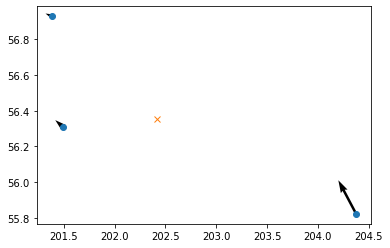

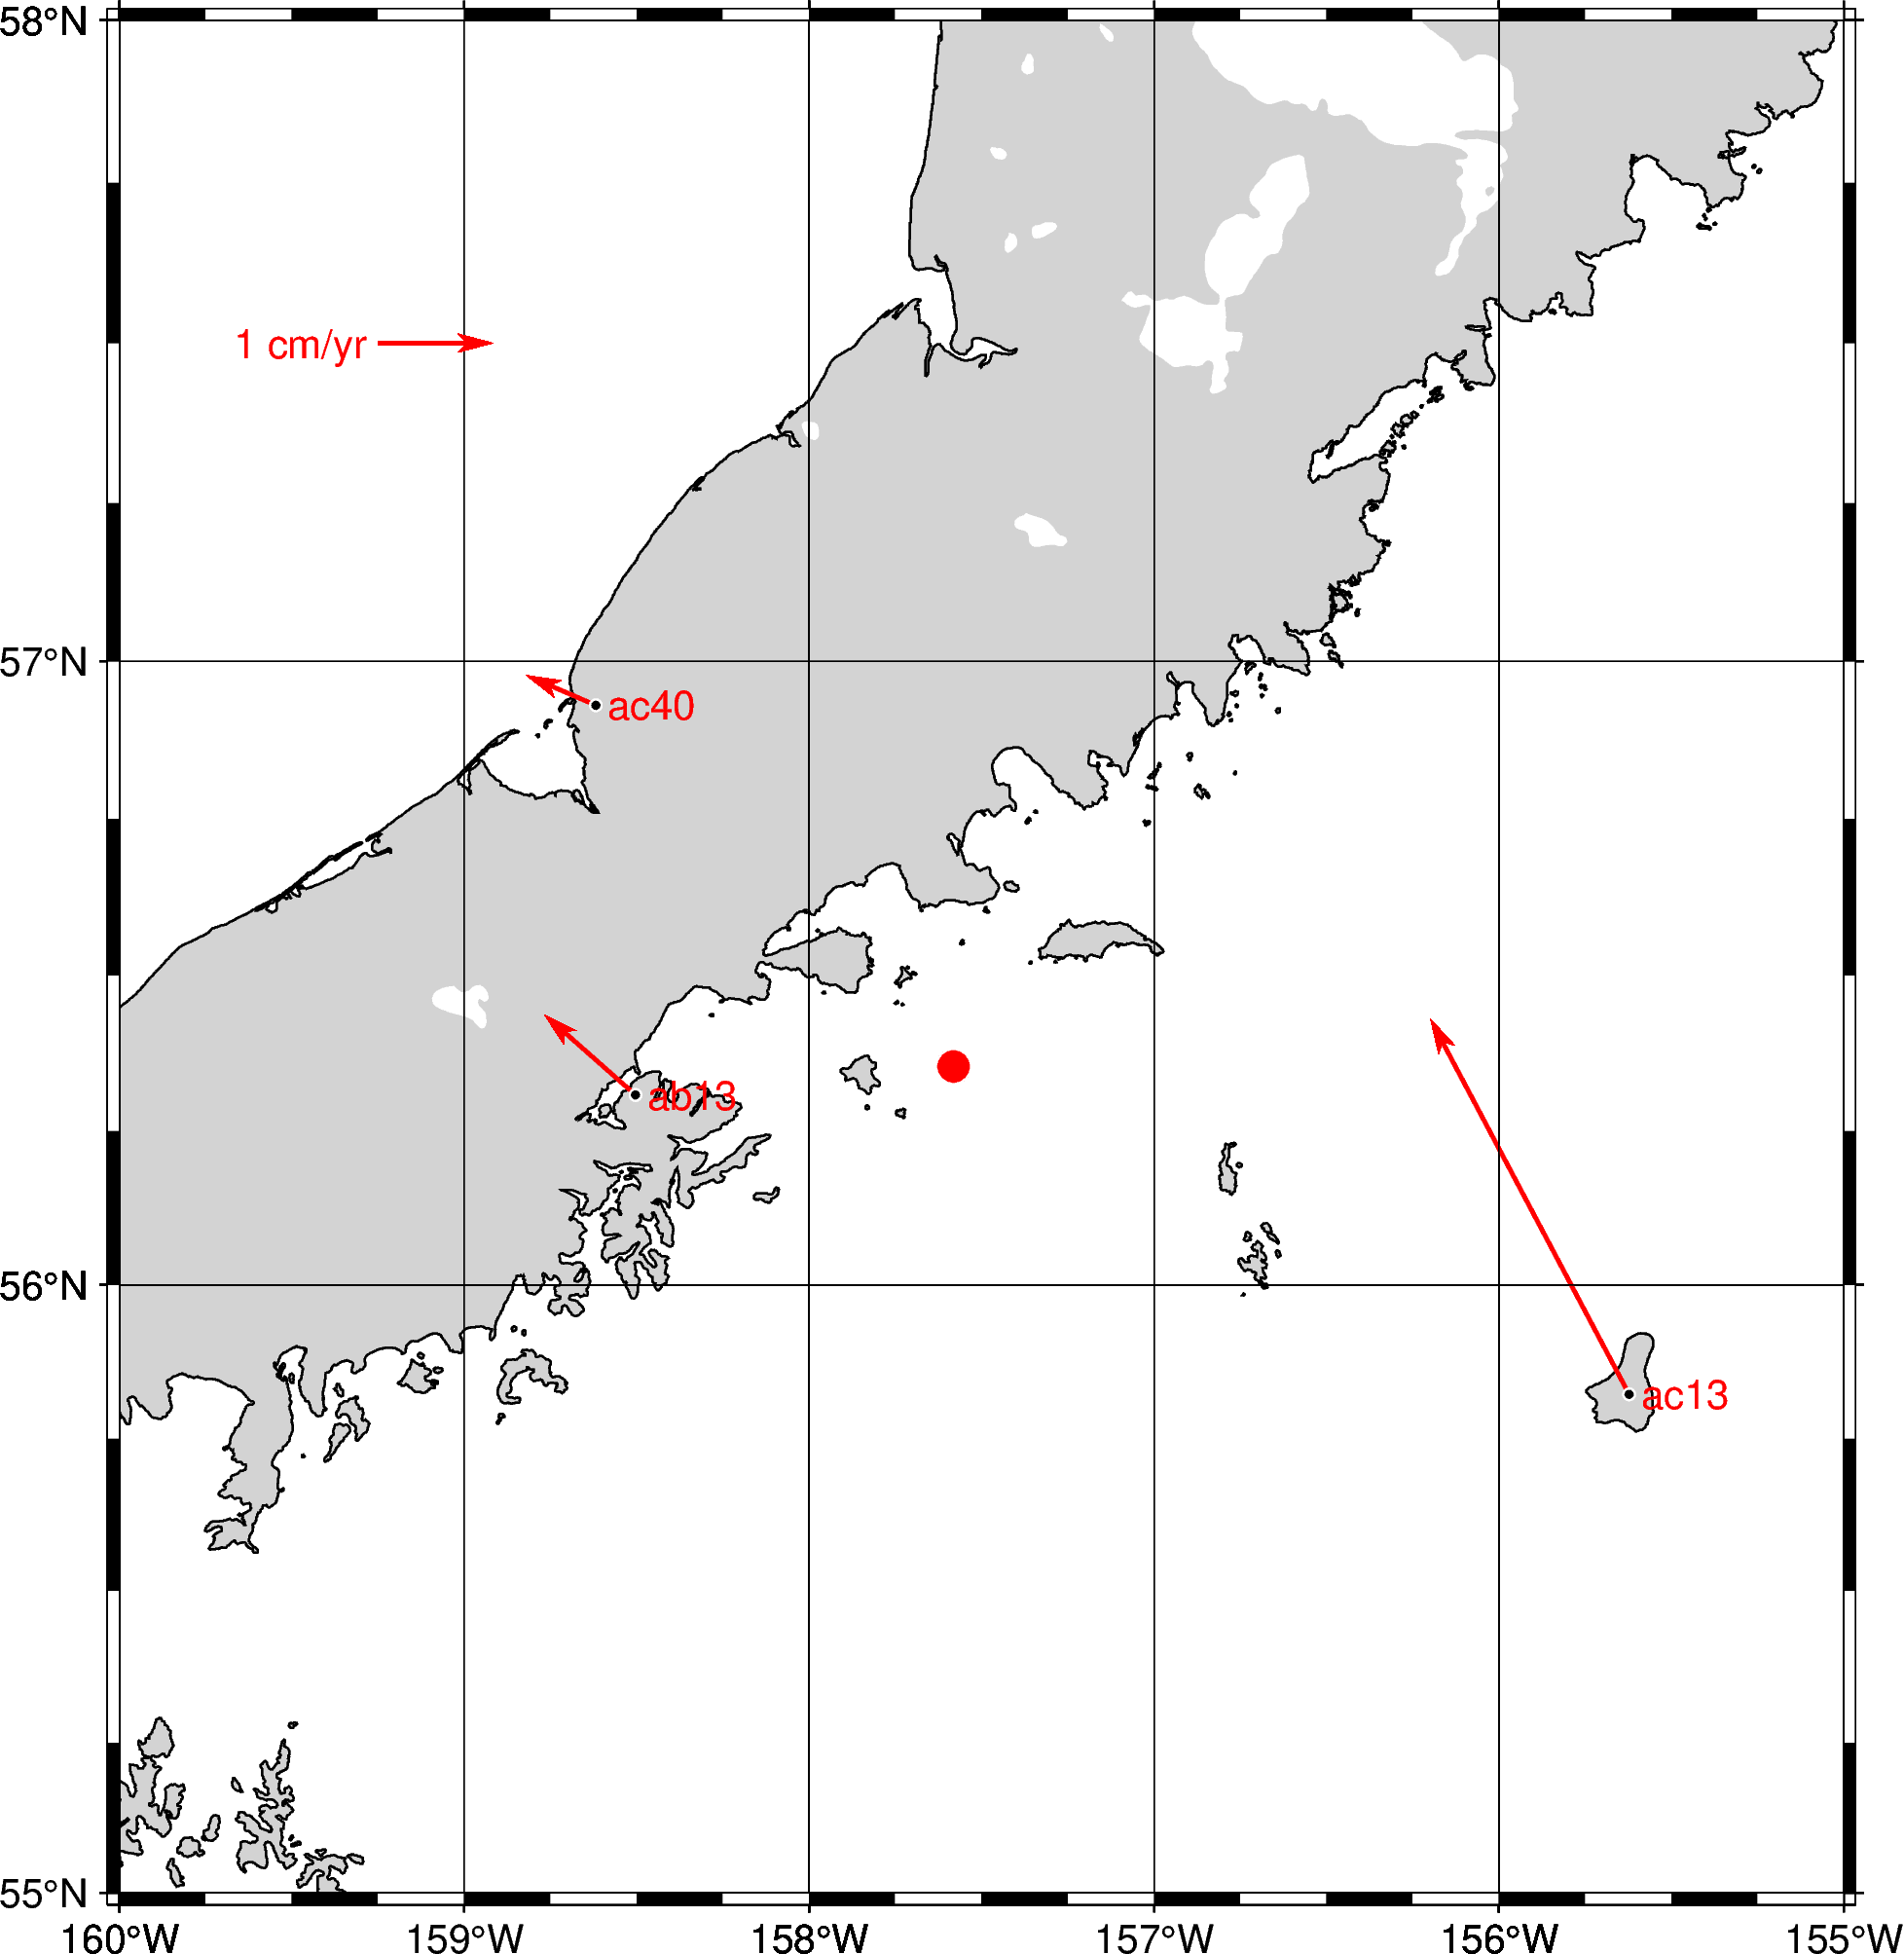

In [8]:
#get indices of the test sites, make sure to use the last entry as there are some sites 
#with solutions for different time periods
ab13 = ak.index[ak['*Dot#']=="AB13"][-1]
ac13 = ak.index[ak['*Dot#']=="AC13"][-1]
ac40 = ak.index[ak['*Dot#']=="AC40"][-1]

#set arrays of longitude, latitude and velocities for these sites
elon = [ak.iloc[x]["Ref_Elong"] for x in [ab13, ac13, ac40]]
nlat = [ak.iloc[x]["Ref_Nlat"]  for x in [ab13, ac13, ac40]]

#SYNTHETIC CASE 1
evel = np.array([-0.015000,-0.015000,-0.015000])
nvel = np.array([-0.005000,-0.005000,-0.005000])

#SYNTHETIC CASE 2
#evel = np.array([-0.005672,0.012049,-0.006378])
#nvel = np.array([-0.000509,-0.005897,0.006406])

#SYNTHETIC CASE 3
#evel = np.array([0.011343,-0.024099,0.012755])
#nvel = np.array([0.001018,0.011795,-0.012813])

##REAL DATA CASE
#evel = [ak.iloc[x]["dE/dt"]     for x in [ab13, ac13, ac40]]
#nvel = [ak.iloc[x]["dN/dt"]     for x in [ab13, ac13, ac40]]

centroids = []

#determine the centroid of the triangle
xcentroid = np.mean(elon);
ycentroid = np.mean(nlat);

#store the coordinates in a list
centroids.append([xcentroid, ycentroid])

# Initialize output arrays.
rot = [];
exx, exy, eyy = [], [], [];

#make a simple plot (sufficient here)
plt.plot(elon, nlat, 'o')
plt.quiver(elon, nlat, evel, nvel)
plt.plot(xcentroid, ycentroid, 'x')
plt.show()

#plot it on a map
vec_spec = "e100/0.95/10"
fig = pygmt.Figure()
fig.coast( 
    region="-160/-155/55/58",
    projection="M15c",
    land="lightgray",
    water="white",
    shorelines="1/0.5p",
    frame="ag",
)

df = pd.DataFrame(
    data={
        "x": elon,
        "y": nlat,
        "east_velocity": evel,
        "north_velocity": nvel,
        "SITE": ["ab13", "ac13", "ac40"]
    }
)
fig.velo(
    data=df,
    pen="0.2p,red",
    line=True,
    spec=vec_spec,
    frame=["WSne", "2g2f"],
    vector="0.3c+p1p+e+gred",
)

##add scale vector
df = pd.DataFrame(
    data={
        "x": [-159.25],
        "y": [57.5],
        "east_velocity": [0.01],
        "north_velocity": [0],
        "SITE": "1 cm/yr"
    }
)

fig.velo(
    data=df,
    pen="0.2p,red",
    line=True,
    spec=vec_spec,
    frame=["WSne", "2g2f"],
    vector="0.3c+p1p+e+gred",
)

#station locations
fig.plot(x=elon, y=nlat, style='c0.04i', color='black', pen='0.4p,white');

#centroid location
fig.plot(x=xcentroid, y=ycentroid, style='c0.12i', color='red', pen='0.4p,white');

fig.show()

## Single Triangle Inversion

In a new code cell below, implement the inversion to infer the horizontal strain field from observed horizontal GNSS velocities (given in m/yr). You'll need to deal with three elements:

* observation vector $d$: a 1x6 column vector of horizontal GNSS velocities 
* model vector $m$: a 1x6 column vector that holds in the first two rows the elements of the translation vector, and the remaining 4 rows contain the elements of the velocity / deformation gradient tensor.
* design matrix $G$:  a 6x6 matrix that will contain placeholders to determine the translation vector in east and north components, and 4 columns holding information about the location vector coordinates (difference between GPS station and strain triangle centroid in meters for east and north components of the distance vector). To determine the distance elements, assume a flat earth, use simple geometry to determine east and north distances.

You arrive at the familar expression of $d=Gm$. To solve this for $m$, you can leverage numpy's `lstsq` method of the `linalg` package. Before you go ahead with this, though, write out the elements of $m, d, G$ in a new text cell below. You may want to start by writing out the information I am giving in the notes above. It helps to think of velocity in terms of strain rate (maybe write that equation out first) and keep in mind that we consider deformation with respect to the centroid of the triangle! Decompose distances into east and north component.



For each of the 4 velocity sets given above, solve the equation for $m$, i.e. infer the model parameters: translation vector and the velocity tensor components. From the latter, calculate the unique 3 strain components (2 normal, 1 shear) and the one rotation component. 

Recall that the 2-D strain tensor is:

$$
\varepsilon_{ij} =  \begin{bmatrix}
                        \epsilon_{xx} & \epsilon_{xy} \\ 
                        \epsilon_{yx} & \epsilon_{yy} \\ 
                    \end{bmatrix}
$$

The 2-D rotation tensor is:

$$
\omega_{ij} =  \begin{bmatrix}
                        0 & \frac{\epsilon_{xy} + \epsilon_{yx}}{2} \\ 
                        \frac{\epsilon_{yx} - \epsilon_{xy}}{2} & 0 \\ 
                    \end{bmatrix}
$$

For each case, in a new text cell below, make statements about (and please include the correct units):
 * magnitude and direction of translation of the triangle centroid
 * create a plot similar to the one above, where you calculate the velocities from your inferred model parameters - how well does your solution agree with the observed data?
 * calculate the dilatation. Is the triangle contracting or expanding? Does your solution make sense compared to the vectors above?
 * calculate the rotation of the triangle (in degrees, please)
 * ignoring the actual tectonic setting of these stations, what kind of tectonic environment do the synthetic cases represent?
 
 Ideally you'll have one code cell that provides the solution and 4 text cells that discuss your solutions for each case. Please include figures of the orginal data and your forward modeled data for each case into these cells (also include figure files in your submission). 